[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RadimKozl/JLNN/blob/main/examples/JLNN_weighted_rules.ipynb)

# **JLNN – Weighted Rules & Multiple Antecedents**

This notebook demonstrates more advanced logic modeling in JLNN:
1. **Rule Weight:** How much we trust the entire rule (e.g., an expert says, "This rule is 80% correct").
2. **Feature Weights:** How important the individual inputs are in the conjunction.
3. **Uncertainty Transfer:** Tracking how uncertainty from the inputs propagates through the weighted rule to the outcome.

#### **Rule:** `0.8 :: A & [w]B -> C`
- The entire rule has a fixed weight of **0.8**.
- Input **A** has a fixed weight of **1.0**.
- Input **B** has a variable weight of **w**, which we will test.

## ***1. Installation and automatic restart***

In [1]:
try:
    import jlnn
    from flax import nnx
    import jax.numpy as jnp
    print("✅ JLNN and JAX are ready.")
except ImportError:
    print("🚀 Installing JLNN from GitHub and fixing JAX for Colab...")
    # Instalace frameworku
    #!pip install jax-lnn --quiet
    !pip install git+https://github.com/RadimKozl/JLNN.git
    # Fix JAX/CUDA compatibility for 2026 in Colab
    !pip install --upgrade "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

    import os
    print("\n🔄 RESTARTING ENVIRONMENT... Please wait a second and then run the cell again.")
    os.kill(os.getpid(), 9)
    os.kill(os.getpid(), 9) # After this line, the cell stops and the environment restarts

✅ JLNN and JAX are ready.


## ***2. Imports and initialization***

In [2]:
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt

# JLNN core imports
from jlnn.symbolic.compiler import LNNFormula
from jlnn.nn.predicates import FixedPredicate
from jlnn.nn.gates import WeightedAnd, WeightedImplication

In [3]:
print("JLNN framework ready.")

JLNN framework ready.


## ***3. Definition of test function***
This function dynamically compiles the rule and sets the weights in the graph.

Basic rule template<br>
`0.8::` defines the consequent weight <br>
`[w]` is a placeholder for the weight of the second input

In [4]:
base_rule = "0.8 :: A & B -> C"

## ***4. Test data***

In [5]:
crisp_inputs = {
    "A": jnp.array([[1.0, 1.0]]),
    "B": jnp.array([[1.0, 1.0]]),
    "C": jnp.array([[0.0, 1.0]])    # The goal begins as complete uncertainty
}

In [6]:
fuzzy_inputs = {
    "A": jnp.array([[0.80, 0.95]]),
    "B": jnp.array([[0.60, 0.85]]),
    "C": jnp.array([[0.0, 1.0]])    # The goal begins as complete uncertainty
}

In [7]:
def run_weighted_rule(w: float, inputs: dict):
    # 1. Compiling the rule
    model = LNNFormula(base_rule, nnx.Rngs(42))

    # 2. Scales Adjustment (Surgery)
    for path, module in nnx.iter_modules(model):
        if isinstance(module, WeightedAnd):
            module.weights.value = jnp.array([1.0, w])
            if hasattr(module, 'beta'):
                module.beta.value = jnp.array(1.0)

        if isinstance(module, WeightedImplication):
            if hasattr(module, 'beta'):
                module.beta.value = jnp.array(1.0)

    # 3. Grounding: Switch to FixedPredicate for all nodes in inputs
    for name in inputs:
        if name in model.predicates:
            model.predicates[name].predicate = FixedPredicate()

    # 4. Inference
    # Now KeyError won't occur because "C" exists in inputs
    output = model(inputs)

    # 5. Extracting the result [L, U]
    flat_output = jnp.reshape(output, (-1, 2))
    L, U = flat_output[0, 0].item(), flat_output[0, 1].item()
    width = U - L

    return L, U, width

## ***5. Running an experiment***

In [8]:
weights = jnp.linspace(0.0, 1.0, 11)

In [9]:
crisp_results = []
fuzzy_results = []

In [10]:
print(f"{'Váha w':<8} | {'Crisp C [L, U]':<18} | {'Fuzzy C [L, U]':<18}")
print("-" * 55)

Váha w   | Crisp C [L, U]     | Fuzzy C [L, U]    
-------------------------------------------------------


In [11]:
for w in weights:
    cL, cU, cW = run_weighted_rule(float(w), crisp_inputs)
    fL, fU, fW = run_weighted_rule(float(w), fuzzy_inputs)

    crisp_results.append((cL, cU, cW))
    fuzzy_results.append((fL, fU, fW))

    print(f"{float(w):<8.1f} | [{cL:.3f}, {cU:.3f}] | [{fL:.3f}, {fU:.3f}]")

0.0      | [0.000, 1.000] | [0.050, 1.000]
0.1      | [0.000, 1.000] | [0.065, 1.000]
0.2      | [0.000, 1.000] | [0.080, 1.000]
0.3      | [0.000, 1.000] | [0.095, 1.000]
0.4      | [0.000, 1.000] | [0.110, 1.000]
0.5      | [0.000, 1.000] | [0.125, 1.000]
0.6      | [0.000, 1.000] | [0.140, 1.000]
0.7      | [0.000, 1.000] | [0.155, 1.000]
0.8      | [0.000, 1.000] | [0.170, 1.000]
0.9      | [0.000, 1.000] | [0.185, 1.000]
1.0      | [0.000, 1.000] | [0.200, 1.000]


## ***6. Visualization***

### ***Expanding results for a chart***

In [12]:
c_L, c_U, c_width = zip(*crisp_results)
f_L, f_U, f_width = zip(*fuzzy_results)

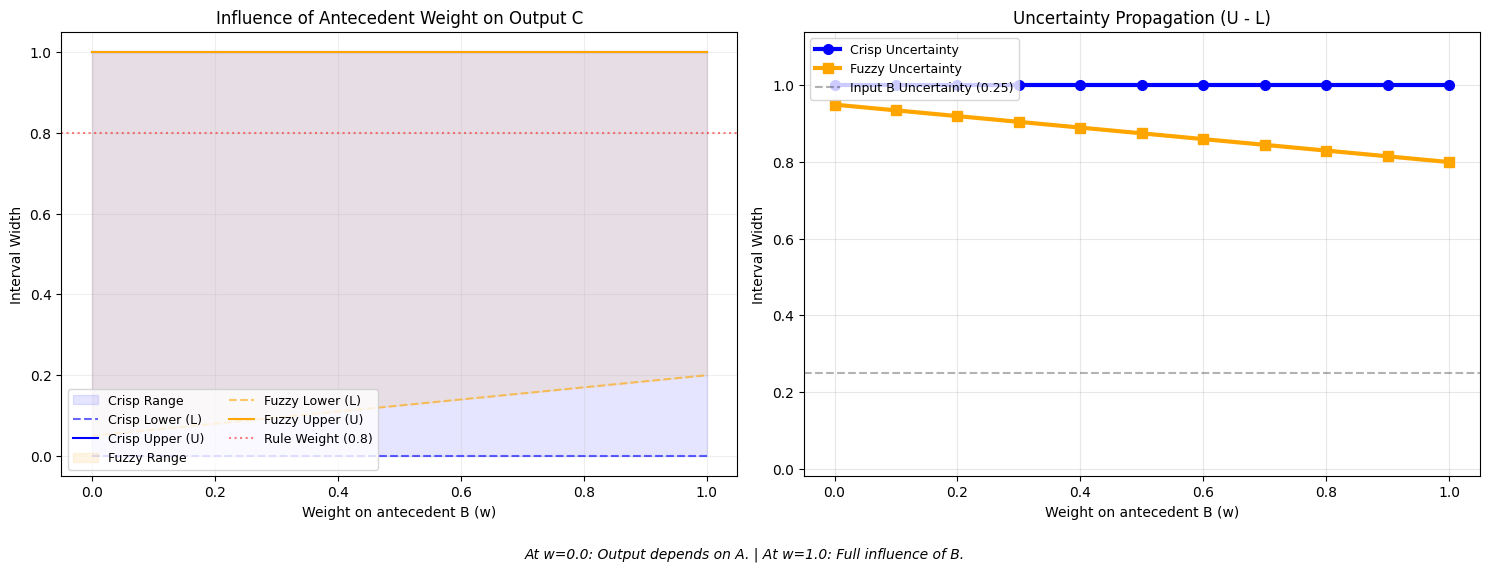

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# --- Graf 1: Intervaly ---
ax1.fill_between(weights, c_L, c_U, color='blue', alpha=0.1, label='Crisp Range')
ax1.plot(weights, c_L, '--', color='blue', alpha=0.6, label='Crisp Lower (L)')
ax1.plot(weights, c_U, '-', color='blue', label='Crisp Upper (U)')
ax1.fill_between(weights, f_L, f_U, color='orange', alpha=0.1, label='Fuzzy Range')
ax1.plot(weights, f_L, '--', color='orange', alpha=0.6, label='Fuzzy Lower (L)')
ax1.plot(weights, f_U, '-', color='orange', label='Fuzzy Upper (U)')
ax1.axhline(y=0.8, color='red', linestyle=':', alpha=0.5, label='Rule Weight (0.8)')
ax1.set_title("Influence of Antecedent Weight on Output C")
ax1.set_ylim(-0.05, 1.05)
ax1.legend(loc='lower left', fontsize=9, ncol=2)
ax1.set_xlabel('Weight on antecedent B (w)')
ax1.set_ylabel("Interval Width")
ax1.grid(True, alpha=0.2)

# --- Chart 2: Width of uncertainty ---
# We use linewidth=3 and zorder to make the lines "break" the axis
ax2.plot(weights, c_width, 'o-', label='Crisp Uncertainty', color='blue',
         linewidth=3, markersize=7, zorder=5)
ax2.plot(weights, f_width, 's-', label='Fuzzy Uncertainty', color='orange',
         linewidth=3, markersize=7, zorder=4)

# Input width reference line B (0.25)
b_uncertainty = 0.85 - 0.60
ax2.axhline(y=b_uncertainty, color='black', linestyle='--', alpha=0.3,
            label=f'Input B Uncertainty ({b_uncertainty:.2f})')

ax2.set_title("Uncertainty Propagation (U - L)")
ax2.set_xlabel("Weight on antecedent B (w)")
ax2.set_ylabel("Interval Width")


# THIS LINE IS KEY:
# We set the upper limit according to the real data (fuzzy_width),
# so that the graph is not "drowned" in the 0-1 scale
max_w = max(max(f_width), b_uncertainty) * 1.2
ax2.set_ylim(-0.02, max_w if max_w > 0 else 0.4)

ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

plt.figtext(0.5, 0.01, "At w=0.0: Output depends on A. | At w=1.0: Full influence of B.",
            ha='center', fontsize=10, style='italic')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## ***7. Analysis of results***

### *What did we find out?*

1. ***Rule Weight as an "Epistemic Ceiling":***
    - Look at the left graph (Crisp L/U). Even when both inputs *A* and *B* are *1.0* (perfectly true), the upper bound *U* of the result never exceeds **0.8**.<br><br>
    - **Insight:** In JLNN, the rule weight (`0.8 ::`) represents our maximum confidence in the implication itself. No matter how certain the evidence is, the conclusion remains within the bounds of the rule's credibility.<br><br>

2. ***Feature Weight as an "Uncertainty Filter":***
    - Look at the right graph (Uncertainty Width). At w=0.0, the uncertainty of the fuzzy result is at its minimum, almost identical to the crisp case.<br><br>
    - **Insight:** Even if input *B* is highly uncertain (wide interval), setting its weight to *0.0* effectively "mutes" its impact. The uncertainty of the output only begins to grow once we start "listening" to the uncertain input by increasing its weight.<br><br>

3. ***Strictness of Weighted Conjunction:***
    - As the weight *w* of input *B* increases, the lower bound *L* decreases.<br><br>
    - **Insight:** *A weighted AND* is "more demanding." By giving more importance to an input that isn't perfectly true, we are providing more reasons for the lower bound of the entire conjunction to drop.<br><br>

----------------------------------------------------------------------------
***Summary of "Aha!" Moments***

>*"A rule is only as strong as its weakest link, but only if you decide that link actually matters (weight > 0)."*




